In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
import logging
import numpy as np
import os
import shutil 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

INFO:__main__:Инициализировали логгер
INFO:__main__:Подключили диск
INFO:__main__:Содержимое директории /content/drive/MyDrive: ['winemag-data-130k-v2.csv', 'Colab Notebooks', 'test_images.zip', 'usdc_train (1).json', 'Lab3', 'data_aug.zip', 'custom_model1_submission_file (2).json', 'yolov6_training', 'test_14052023', 'dataset.yaml', 'test_15', 'train_images.zip', 'usdc_test.json', 'train_images', 'Unpacked', 'Unpacked1', 'usdc_train.json', 'sunmission.json', 'test_images', 'insurance.csv', 'IMDB-Movie-Data.csv', 'client_segmentation.csv']


Mounted at /content/drive


In [2]:
# Загрузка данных
data_path = os.path.join(root_data_dir, 'winemag-data-130k-v2.csv')
data = pd.read_csv(data_path)

# Выбор необходимых колонок
selected_columns = ['description', 'points', 'price']
data = data[selected_columns]

In [3]:
# Предобработка текстовых данных
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Токенизация
    tokens = word_tokenize(text)
    
    # Удаление стоп-слов и лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    
    # Объединение токенов обратно в текст
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data['preprocessed_description'] = data['description'].apply(preprocess_text)

In [5]:
from sklearn.decomposition import TruncatedSVD

# Векторизация текстовых данных с использованием TF-IDF
vectorizer = TfidfVectorizer()

text_vectors = vectorizer.fit_transform(data['preprocessed_description'])

# Уменьшение размерности с использованием TruncatedSVD
svd = TruncatedSVD(n_components=2)
reduced_vectors = svd.fit_transform(text_vectors)

In [6]:
# Кластеризация с использованием K-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(text_vectors)

# Получение меток кластеров
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# Оценка кластеризации с помощью inertia и silhouette score
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(text_vectors, cluster_labels)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette_avg)

Inertia: 125473.06082353533
Silhouette Score: 0.004080754943452634


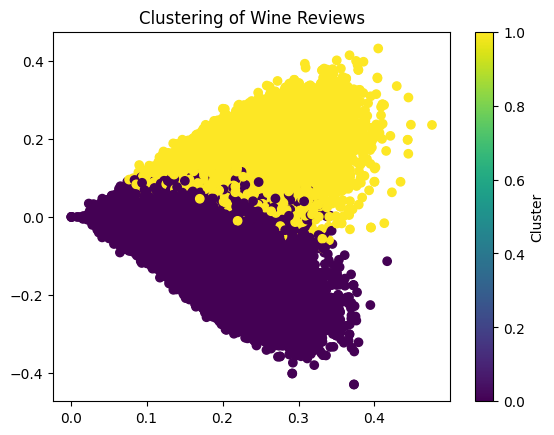

In [8]:
import matplotlib.pyplot as plt

# Визуализация кластеров
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering of Wine Reviews')
plt.colorbar(label='Cluster')
plt.show()

# Каждая точка на графике представляет собой один образец данных, а цвет точки 
# указывает на принадлежность кластеру. Oбразцы группируются по кластерам, 
# можно увидеть скопления точек одного цвета, что указывает на схожие 
# характеристики между образцами внутри каждого кластера. Только некоторые 
# объекты путаются между собой.

In [9]:
from sklearn.cluster import MiniBatchKMeans

# Кластеризация с использованием MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=2)
cluster_labels = minibatch_kmeans.fit_predict(text_vectors)

inertia = minibatch_kmeans.inertia_
silhouette_avg = silhouette_score(text_vectors, cluster_labels)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia: 125564.66029934434
Silhouette Score: 0.0063398178554499715


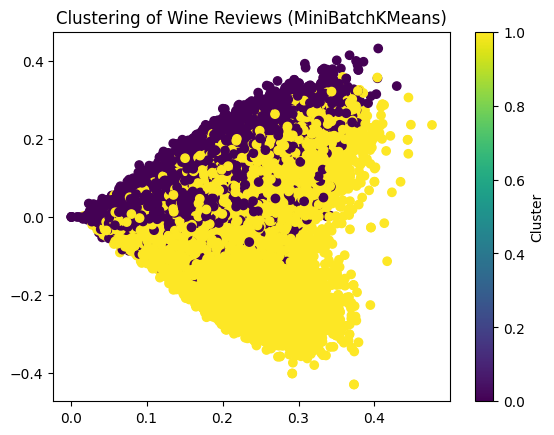

In [10]:
# Рисуем кластеры
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering of Wine Reviews (MiniBatchKMeans)')
plt.colorbar(label='Cluster')
plt.show()

# Видим что этот алгоритм менее точен и имеет много спорных точек, 
# так же видим изменения значений метрик.